In [2]:
import pandas as pd
import numpy as np
from datetime import datetime

In [3]:
data=pd.read_csv('../data/crsp_stock_data.csv')
data.head(5)

/Users/jacobbarcelona/.pyenv/versions/3.9.16/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3526: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,PERMNO,date,TICKER,COMNAM,PRC,RET,SHROUT,CFACPR,CFACSHR
0,10001,1990-01-02,GFGC,GREAT FALLS GAS CO,10.1250,0.000000,1022.0,3.0,3.0
1,10001,1990-01-03,GFGC,GREAT FALLS GAS CO,10.0000,-0.012346,1022.0,3.0,3.0
2,10001,1990-01-04,GFGC,GREAT FALLS GAS CO,10.0000,0.000000,1022.0,3.0,3.0
3,10001,1990-01-05,GFGC,GREAT FALLS GAS CO,-10.0625,0.006250,1022.0,3.0,3.0
4,10001,1990-01-08,GFGC,GREAT FALLS GAS CO,10.1250,0.006211,1022.0,3.0,3.0


In [4]:
factors=pd.read_csv('../data/F-F_Research_Data_Factors.CSV')
factors

,date,Mkt-RF,SMB,HML,RF
0,192607,2.96,-2.56,-2.43,0.22
1,192608,2.64,-1.17,3.82,0.25
2,192609,0.36,-1.40,0.13,0.23
3,192610,-3.24,-0.09,0.70,0.32
4,192611,2.53,-0.10,-0.51,0.31
...,...,...,...,...,...
1160,202303,2.51,-5.51,-8.85,0.36
1161,202304,0.61,-3.35,-0.04,0.35
1162,202305,0.35,1.61,-7.72,0.36
1163,202306,6.46,1.54,-0.26,0.40


In [5]:
import pandas as pd

# Assuming 'data' is your original stock data

# Convert 'date' to datetime and add a 'MonthYear' column
data['date'] = pd.to_datetime(data['date'])
data['MonthYear'] = data['date'].dt.to_period('M')

# Step 1: Exclude Negative Prices and 0 prices and Calculate Market Cap
data['MktCap'] = data.apply(lambda x: x['PRC'] * x['SHROUT'] if x['PRC'] > 0 else pd.NA, axis=1)

data['MktCap'] = pd.to_numeric(data['MktCap'], errors='coerce')

# Step 2: Use Last Day of Each Month for Market Cap Calculation
# Get the last trading day for each month
last_day_each_month = data.groupby('MonthYear')['date'].transform('max')
data_last_day = data[data['date'] == last_day_each_month]

# Select Top 500 Firms based on Market Cap on the Last Day of Each Month
top500_last_day = data_last_day.groupby('MonthYear', as_index=False).apply(lambda x: x.nlargest(500, 'MktCap')).reset_index(drop=True)

# Preparing for Next Month's Data
top500_last_day['NextMonth'] = top500_last_day['MonthYear'].apply(lambda x: x + 1)
top500_map = top500_last_day[['NextMonth', 'TICKER']].drop_duplicates()

# Step 3: Merge with Original Data for the Next Month
data['NextMonth'] = data['MonthYear']
resulting_df = pd.merge(data, top500_map, left_on=['NextMonth', 'TICKER'], right_on=['NextMonth', 'TICKER'])

# Select Relevant Columns for the Resulting DataFrame
resulting_df = resulting_df[['date', 'TICKER', 'RET', 'MktCap']]

# Sort the DataFrame by date
resulting_df = resulting_df.sort_values(by='date')

# Output the resulting DataFrame
print(resulting_df.head())


              date TICKER       RET       MktCap
0       1990-02-01   SUNW  0.012903  1674149.875
768198  1990-02-01    TXT  0.011628  1933161.750
2332894 1990-02-01  IHEIF  0.006623          NaN
775521  1990-02-01    CTZ -0.027397  1620530.625
775670  1990-02-01    PEG -0.004587  5726087.500


In [6]:
# import pandas as pd

# # Assuming 'df' is your stock data and 'factors' is your Fama-French factors data

# # Step 1: Calculate Market Cap
# data['MktCap'] = data['PRC'] * data['SHROUT']

# # Step 2: Identify Top 500 Companies by Market Cap
# data['date'] = pd.to_datetime(data['date'])
# data = data.sort_values(['date', 'MktCap'], ascending=[True, False])
# data['MonthYear'] = data['date'].dt.to_period('M')

# # Group by MonthYear and select the top firms up to 500
# top500 = data.groupby('MonthYear').apply(lambda x: x.nlargest(min(500, len(x)), 'MktCap')).reset_index(drop=True)

# # Step 3: Create a LaggedMonthYear column that represents the previous month
# top500['LaggedMonthYear'] = top500['MonthYear'].apply(lambda x: x - 1)

# # Merging with Fama-French factors
# factors['date'] = pd.to_datetime(factors['date'], format='%Y%m')
# factors['MonthYear'] = factors['date'].dt.to_period('M')
# merged_data = pd.merge(top500, factors, left_on='LaggedMonthYear', right_on='MonthYear')
# # Convert columns to numeric if they are not already
# cols_to_convert = ['RET', 'Mkt-RF', 'SMB', 'HML', 'RF']

# for col in cols_to_convert:
#     merged_data[col] = pd.to_numeric(merged_data[col], errors='coerce')

# # Handling NaN values for numeric columns
# numeric_cols = merged_data.select_dtypes(include=['number']).columns
# merged_data[numeric_cols] = merged_data[numeric_cols].fillna(0)
# # Step 4: Calculate Adjusted Returns
# merged_data['Adj_RET_Mkt'] = merged_data['RET'] - merged_data['Mkt-RF'] - merged_data['RF']
# merged_data['Adj_RET_Mkt_SMB'] = merged_data['RET'] - merged_data['Mkt-RF'] - merged_data['SMB'] - merged_data['RF']
# merged_data['Adj_RET_Mkt_SMB_HML'] = merged_data['RET'] - merged_data['Mkt-RF'] - merged_data['SMB'] - merged_data['HML'] - merged_data['RF']

# # Selecting relevant columns for the resulting dataframe
# resulting_df = merged_data[['date_x', 'TICKER', 'RET', 'Adj_RET_Mkt', 'Adj_RET_Mkt_SMB', 'Adj_RET_Mkt_SMB_HML']]
# resulting_df.rename(columns={'date_x': 'date'}, inplace=True)

# Your resulting_df is now ready with the adjusted returns


In [7]:
import pandas as pd

# Convert 'MonthYear_x' and 'MonthYear_y' back to datetime for comparison
merged_data['MonthYear_x'] = merged_data['MonthYear_x'].dt.to_timestamp()
merged_data['MonthYear_y'] = merged_data['MonthYear_y'].dt.to_timestamp()

# Check if any row has a 'MonthYear_x' that is not exactly one month ahead of 'MonthYear_y'
date_mismatch = merged_data[merged_data['MonthYear_x'] != (merged_data['MonthYear_y'] + pd.DateOffset(months=1))]
if date_mismatch.empty:
    print("Date alignment check passed: All rows have correct month-year alignment.")
else:
    print("Date alignment check failed. Review the following rows:")
    print(date_mismatch)



date_mismatch


NameError: name 'merged_data' is not defined

In [ ]:
#Get the stocks starting from febuary
resulting_df=resulting_df[resulting_df['date']>=datetime(1990,2,1)]
resulting_df.sort_values(by=['date'])

,date,TICKER,RET,MktCap
0,1990-02-01,SUNW,0.012903,1.674150e+06
1697337,1990-02-01,BUD,-0.026490,1.039198e+07
1702077,1990-02-01,CB,0.005634,3.800800e+06
1778790,1990-02-01,NWL,0.000000,1.370053e+06
1771786,1990-02-01,SPC,-0.006920,4.057319e+06
...,...,...,...,...
2853484,2015-12-31,XLF,-0.009971,1.937605e+07
2981157,2015-12-31,ISRG,-0.011493,2.042638e+07
2789581,2015-12-31,CM,-0.009623,2.617265e+07
1894695,2015-12-31,D,-0.015143,4.026839e+07


In [10]:
resulting_df[resulting_df['date']==datetime(2000,3,2)]

,date,TICKER,RET,MktCap
2695175,2000-03-02,RX,0.022436,6.139295e+06
2926133,2000-03-02,INAP,-0.083493,1.132443e+07
988086,2000-03-02,K,-0.039474,9.248279e+06
1125206,2000-03-02,MAS,-0.003436,8.035556e+06
2002200,2000-03-02,GMH,0.010042,1.614054e+07
...,...,...,...,...
2932088,2000-03-02,FNSR,-0.022351,6.855835e+06
370560,2000-03-02,UK,-0.054187,6.425184e+06
903157,2000-03-02,CMA,-0.012069,5.600788e+06
2580060,2000-03-02,ASML,-0.007018,1.952700e+07


In [6]:
#verify that resulting df has 500 stocks per date
import pandas as pd

# Assuming 'resulting_df' is your dataframe

# Group by date and count unique TICKERs for each date
ticker_count_per_date = resulting_df.groupby('date')['TICKER'].nunique()

# Check if all dates have exactly 500 stocks
all_dates_have_500_stocks = ticker_count_per_date.eq(500).all()

# Output the result
if all_dates_have_500_stocks:
    print("Verification passed: All dates have exactly 500 stocks.")
else:
    print("Verification failed: Some dates do not have exactly 500 stocks.")
    # Optionally, display dates that do not have 500 stocks
    print("Dates with a number of stocks different from 500:")
    print(ticker_count_per_date[ticker_count_per_date != 500])


Verification failed: Some dates do not have exactly 500 stocks.
Dates with a number of stocks different from 500:
date
1990-02-09    499
1990-02-12    499
1990-02-13    499
1990-02-14    499
1990-02-15    499
             ... 
2015-12-24    497
2015-12-28    497
2015-12-29    496
2015-12-30    496
2015-12-31    496
Name: TICKER, Length: 6310, dtype: int64


In [13]:
resulting_df_original=pd.read_csv('../data/crsp_ff_adjusted.csv')
resulting_df_original

,Unnamed: 0,date,TICKER,RET,Adj_RET_Mkt,Adj_RET_Mkt_SMB,Adj_RET_Mkt_SMB_HML
0,0,1990-02-01,SUNW,0.012903,7.292903,8.532903,7.682903
1,243076,1990-02-01,MYG,0.014085,7.294085,8.534085,7.684085
2,1688937,1990-02-01,INTC,-0.012658,7.267342,8.507342,7.657342
3,1680427,1990-02-01,CB,0.005634,7.285634,8.525634,7.675634
4,1675688,1990-02-01,BUD,-0.026490,7.253510,8.493510,7.643510
...,...,...,...,...,...,...,...
3266862,228605,2015-12-31,KMI,0.026135,-0.533865,-4.133865,-3.713865
3266863,66360,2015-12-31,ADM,-0.005423,-0.565423,-4.165423,-3.745423
3266864,374087,2015-12-31,HPE,-0.005236,-0.565236,-4.165236,-3.745236
3266865,954405,2015-12-31,DIS,-0.011849,-0.571849,-4.171849,-3.751849


In [14]:
resulting_df['date'] = pd.to_datetime(resulting_df['date'])
resulting_df_original['date'] = pd.to_datetime(resulting_df_original['date'])

# Filter for February 1990
feb_1990_df = resulting_df[resulting_df['date'].dt.strftime('%Y-%m') == '1990-02']
feb_1990_df_original = resulting_df_original[resulting_df_original['date'].dt.strftime('%Y-%m') == '1990-02']

# Get sets of tickers for each dataframe
tickers_feb_1990_df = set(feb_1990_df['TICKER'])
tickers_feb_1990_df_original = set(feb_1990_df_original['TICKER'])

# Compare tickers
tickers_only_in_df = tickers_feb_1990_df - tickers_feb_1990_df_original
tickers_only_in_df_original = tickers_feb_1990_df_original - tickers_feb_1990_df
tickers_in_both = tickers_feb_1990_df.intersection(tickers_feb_1990_df_original)

# Output results
print("Tickers only in resulting_df for Feb 1990:", tickers_only_in_df)
print("Tickers only in resulting_df_original for Feb 1990:", tickers_only_in_df_original)
print("Tickers in both dataframes for Feb 1990:", tickers_in_both)

Tickers only in resulting_df for Feb 1990: {'ALEX', 'HB', 'MUR', 'TYC', 'FLR', 'DNP', 'NI', 'VHI', 'ASN', 'VIA', 'NL', 'WH', 'FMC', 'TBS', 'IHEIF', 'MHS', 'I', 'ASH', 'IIN', 'TIN', 'ICI', 'LIT', 'G', 'HAN', 'NSI', 'UAL', 'CSN', 'SFX', 'CITU', 'WMB', 'BDG'}
Tickers only in resulting_df_original for Feb 1990: {'FITB', 'NHL', 'KEY', 'GNP', 'MBI', 'PSD', 'NRT', 'SNS', 'ICR', 'MMT', 'EWSC', 'CXY', 'GWT', 'BEN', 'ADTL', 'HAS', 'HBOL', 'FFC', 'BRNO', 'CMY', 'BMG', 'NUE', 'PPT', 'BC', 'ECP', 'BOAT', 'SLH'}
Tickers in both dataframes for Feb 1990: {'CPC', 'BAX', 'WMK', 'MYG', 'HRB', 'PH', 'JP', 'ROAD', 'RTN', 'RAL', 'SQD', 'BNI', 'CSFN', 'NUV', 'KMB', 'JCI', 'UN', 'PHYB', 'AT', 'NYT', 'UEP', 'WX', 'ARC', 'MAS', 'TXN', 'FNB', 'LK', 'AU', 'MCK', 'SYN', 'OEC', 'IAD', 'VFC', 'XON', 'BP', 'HSY', 'DEC', 'BSC', 'AUD', 'CCB', 'CNG', 'GCI', 'CPH', 'DRY', 'GAS', 'VO', 'ACY', 'ABT', 'RBD', 'ML', 'MDA', 'LDMFB', 'AIT', 'CNT', 'WIN', 'GM', 'N', 'SPS', 'IR', 'TCOMA', 'MMC', 'RTRSY', 'DUK', 'BCC', 'SCG', 'PEG

In [20]:
import pandas as pd

# Assuming 'resulting_df' is your dataframe and 'ff_factors' is your Fama-French factors data

# Convert the date column in ff_factors from yearmonth format to datetime
factors['date'] = pd.to_datetime(factors['date'], format='%Y%m')

# Ensure 'date' in resulting_df is datetime
resulting_df['date'] = pd.to_datetime(resulting_df['date'])

# Since ff_factors are monthly, we'll assign each row in resulting_df to the corresponding month
resulting_df['MonthYear'] = resulting_df['date'].dt.to_period('M')

# Do the same for ff_factors
factors['MonthYear'] = factors['date'].dt.to_period('M')

# Merge the resulting_df with ff_factors based on MonthYear
merged_df = pd.merge(resulting_df, factors, on='MonthYear', how='left')

# Drop the extra MonthYear column if not needed
merged_df.drop(columns=['MonthYear'], inplace=True)

# Calculate Adjusted Returns
merged_df['Adj_RET_Mkt'] = merged_df['RET'] - merged_df['Mkt-RF'] - merged_df['RF']
merged_df['Adj_RET_Mkt_SMB'] = merged_df['RET'] - merged_df['Mkt-RF'] - merged_df['SMB'] - merged_df['RF']
merged_df['Adj_RET_Mkt_SMB_HML'] = merged_df['RET'] - merged_df['Mkt-RF'] - merged_df['SMB'] - merged_df['HML'] - merged_df['RF']

# Output the resulting DataFrame
print(merged_df.head())


      date_x TICKER       RET       MktCap date_y  Mkt-RF  SMB  HML  RF  \
0 1990-02-01   SUNW  0.012903  1674149.875    NaT     NaN  NaN  NaN NaN   
1 1990-02-01    TXT  0.011628  1933161.750    NaT     NaN  NaN  NaN NaN   
2 1990-02-01  IHEIF  0.006623          NaN    NaT     NaN  NaN  NaN NaN   
3 1990-02-01    CTZ -0.027397  1620530.625    NaT     NaN  NaN  NaN NaN   
4 1990-02-01    PEG -0.004587  5726087.500    NaT     NaN  NaN  NaN NaN   

  Adj_RET_Mkt Adj_RET_Mkt_SMB Adj_RET_Mkt_SMB_HML  
0         NaN             NaN                 NaN  
1         NaN             NaN                 NaN  
2         NaN             NaN                 NaN  
3         NaN             NaN                 NaN  
4         NaN             NaN                 NaN  


In [21]:
merged_df

,date_x,TICKER,RET,MktCap,date_y,Mkt-RF,SMB,HML,RF,Adj_RET_Mkt,Adj_RET_Mkt_SMB,Adj_RET_Mkt_SMB_HML
0,1990-02-01,SUNW,0.012903,1.674150e+06,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1990-02-01,TXT,0.011628,1.933162e+06,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1990-02-01,IHEIF,0.006623,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1990-02-01,CTZ,-0.027397,1.620531e+06,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1990-02-01,PEG,-0.004587,5.726088e+06,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
3275583,2015-12-31,HSY,-0.014680,1.394165e+07,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3275584,2015-12-31,HPQ,0.0,2.121548e+07,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3275585,2015-12-31,EIX,-0.018076,1.929127e+07,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3275586,2015-12-31,KR,-0.011345,4.077266e+07,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
resulting_df.to_csv('../data/corrected_crsp_ff_adjusted.csv')

In [8]:
aapl=resulting_df[resulting_df['TICKER']=='AAPL']

In [12]:
aapl

,date,TICKER,RET,MktCap
309350,1990-02-01,AAPL,-0.011029,4.209917e+06
309351,1990-02-02,AAPL,0.018587,4.288168e+06
309352,1990-02-05,AAPL,0.021898,4.382070e+06
309353,1990-02-06,AAPL,-0.007143,4.350770e+06
309354,1990-02-07,AAPL,-0.043165,4.162966e+06
...,...,...,...,...
315411,2015-12-24,AAPL,-0.005340,5.989709e+08
315412,2015-12-28,AAPL,-0.011201,5.922621e+08
315413,2015-12-29,AAPL,0.017974,6.029075e+08
315414,2015-12-30,AAPL,-0.013059,5.950343e+08


In [17]:
aapl['RET'] = pd.to_numeric(aapl['RET'], errors='coerce')

/var/folders/bm/bm_nkxfx3w1303dr6gyz9cg00000gn/T/ipykernel_49538/4209959190.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aapl['RET'] = pd.to_numeric(aapl['RET'], errors='coerce')


In [19]:
len(aapl.isna()

,date,TICKER,RET,MktCap
309350,False,False,False,False
309351,False,False,False,False
309352,False,False,False,False
309353,False,False,False,False
309354,False,False,False,False
...,...,...,...,...
315411,False,False,False,False
315412,False,False,False,False
315413,False,False,False,False
315414,False,False,False,False


<Axes: >

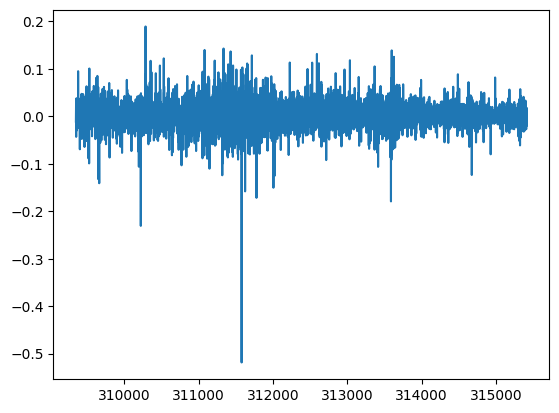

In [18]:
aapl['RET'].plot()